In [176]:
import numpy as np
from numpy import nan
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
from functools import reduce
import matplotlib.pyplot as plt 
import time
from util import read_json_from, write_json_to, eval_relation
from data import proteomeHD_simplified_protein_ids,proteomeHD_feature_matrix,major_simplified_idx_lookup
from data import pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup
from data import nikolai_protein_ids,nikolai_protein_feature_matrix,nikolai_protein_idx_lookup
import copy
#from visualization_util import df_precision_recall_analysis
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")

In [227]:
protein_info_path = f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_info.json"
pQTL_protein_info = read_json_from(protein_info_path)

def get_protein_location(protein_name):
    potential_locations = []
    try:
        for item in pQTL_protein_info[protein_name]['comments']:
            if (item['type'] == "SUBCELLULAR_LOCATION"):
                for location in item['locations']:
                    potential_locations.append(location['location']['value'])
        return potential_locations
    except KeyError:
        return []
    
def shuffle_cliques_node_label(cliques):
    all_unique_node = set()
    for clique in cliques:
        for node in clique:
            all_unique_node.add(node)
    all_unique_node_shuffled = np.array(list(all_unique_node))
    np.random.shuffle(all_unique_node_shuffled)
    shuffled_mapping = {og:new for og,new in zip(list(all_unique_node),all_unique_node_shuffled)}
    new_cliques = []
    for i in range(len(cliques)):
        clique = cliques[i]
        to_build = []
        for j in range(len(clique)):
            to_build.append(shuffled_mapping[clique[j]])
        new_cliques.append(to_build)
    return new_cliques

# kNN
def get_top_k_nearest_neighbors(vector,k,candidates,dist_function):
    k += 1
    dist_to_all = np.array(list(map(lambda x: dist_function(vector,x),candidates)))
    neighbor_indices = np.argpartition(dist_to_all, k)[0:k]
    neighbor_indices = neighbor_indices[np.argsort(dist_to_all[neighbor_indices])]
    neighbor_indices = neighbor_indices[1:]
    top_k_neighbors_dist = dist_to_all[neighbor_indices]
    return neighbor_indices,top_k_neighbors_dist



def get_closest_neighbors_in_embeddings(protein,k,embeddings,lookup,dist_func):
    neighbor_lists = []
    for embedding in embeddings:
        protein_vec = embedding[lookup[protein]]
        neighbor_indices,_ = get_top_k_nearest_neighbors(protein_vec,k,embedding,dist_func)
        neighbor_lists.append(neighbor_indices)
    return neighbor_lists

def get_common_closest_neighbors_in_embeddings(protein,k,embeddings,lookup,dist_func):
    neighbor_lists = get_closest_neighbors_in_embeddings(protein,k,embeddings,lookup,dist_func)
    shared_proteins_indices = reduce(np.intersect1d, neighbor_lists)
    name_list = list(map(lambda x: shared_proteins[x], shared_proteins_indices))
    return name_list

def calc_interaction_count(protein,candidates,interaction='physical'):
    count = 0
    for candidate in candidates:
        relation_report = eval_relation(protein,candidate)
        if interaction == 'physical':
            if relation_report['experiments'] > 0 or relation_report['database'] > 0:
                count += 1
        elif interaction == 'cocomplex':
            if relation_report['cocomplex'] > 0:
                count += 1
    return count

def overall_interaction_counts(proteins,interation_candidates,interaction='physical'):
    assert len(proteins) == len(interation_candidates)
    count_list = []
    for i in range(len(proteins)):
        short_list = []
        # Number of interacting proteins
        short_list.append(calc_interaction_count(proteins[i],interation_candidates[i],interaction))
        # Number of overlapping proteins
        short_list.append(len(interation_candidates[i]))
        count_list.append(short_list)
    return count_list

def convert_prediction_to_df(proteins,interation_candidates,count_matrix):
    assert len(proteins) == len(interation_candidates) and len(proteins) == len(count_matrix)
    predictions = []
    for i in range(len(proteins)):
        for j in range(len(interation_candidates[i])):
            predictions.append((proteins[i],interation_candidates[i][j],count_matrix[i][j]))
    df = pd.DataFrame(predictions, columns =['protein_1', 'protein_2', 'appearance']) 
    return df

def validate_relations_in_df(df):
    binary_interaction = []
    cocomplex = []
    subcellular_location = []
    for idx,row in df.iterrows():
        p1 = row['protein_1']
        p2 = row['protein_2']
        relation_report = eval_relation(p1,p2)
        if relation_report['experiments'] > 0 or relation_report['database'] > 0:
            binary_interaction.append(1)
        else:
            binary_interaction.append(0)
        if relation_report['cocomplex'] > 0:
            cocomplex.append(1)
        else:
            cocomplex.append(0)
        p1_loc = get_protein_location(p1)
        p2_loc = get_protein_location(p2)
        if len(np.intersect1d(p1_loc,p2_loc)) > 0:
            subcellular_location.append(1)
        else:
            subcellular_location.append(0)
    to_return_df = df.copy()
    to_return_df['binary_interaction'] = binary_interaction
    to_return_df['cocomplex'] = cocomplex
    to_return_df['subcellular_location'] = subcellular_location
    return to_return_df


def euclidean_dist(vec1,vec2):
    return np.linalg.norm(vec1-vec2)

def draw_bar(xs,ys,x_label,y_label,title,ylim=None,colors=None):
    x_pos = [i for i, _ in enumerate(xs)]
    plt.bar(x_pos, ys,color=colors)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(x_pos, xs)
    if ylim:
        plt.ylim(ylim)
    plt.show()
    
# Cut an embedding into chunks with size n
def chunk_features(embedding,n):
    columns_to_cut = [ i for i in range(n,embedding.shape[1],n)]
    return np.hsplit(embedding,columns_to_cut)


def calc_appearance_freq(neighbors):
    unique, counts = np.unique(neighbors, return_counts=True)
    return np.asarray((unique, counts)).T

# Indices of the top k element in the given array
def take_top_k(arr,k,desc=False):
    if desc: arr = -arr
    if len(arr) <= k:
        return np.argsort(arr)
    part = np.argpartition(arr,k)[:k]
    correct_order = np.argsort(arr[part])
    return part[correct_order]

def sample_embedding(embedding,chunk_size,sample_size):
    return np.array([embedding[:,np.random.choice(embedding.shape[1], chunk_size, replace=False)] for i in range(sample_size)])

# Keep chunk_size small but neighbor size big
def generate_link_candidates(protein,name_vector,embedding,lookup,neighbor_size=5,chunk_size=5,sample_size=100,candidate_size=5,dist=euclidean_dist,return_all=False):
    protein_vec = embedding[lookup[protein]]
    diff_embeddeding = embedding - protein_vec
    chunked_embeddings = sample_embedding(diff_embeddeding,chunk_size,sample_size)
    #chunked_embeddings = chunk_features(diff_embeddeding,chunk_size)
    candidates = np.zeros((len(chunked_embeddings),neighbor_size))
    for idx,chunk in enumerate(chunked_embeddings):
        norm_vec = np.linalg.norm(chunk, axis=1)
        top_indices = take_top_k(norm_vec,neighbor_size+1)[1:]
        candidates[idx] = top_indices
    interaction_freq_indices = calc_appearance_freq(candidates)
    if return_all:
        top_interacting = name_vector[interaction_freq_indices[:,0].astype(int)]
        interacting_counts = interaction_freq_indices[:,1]
    else:
        top_interacting_indices = take_top_k(interaction_freq_indices[:,1],candidate_size,desc=True)
        interacting_counts = interaction_freq_indices[top_interacting_indices][:,1]
        top_interacting = name_vector[interaction_freq_indices[top_interacting_indices][:,0].astype(int)]
    return top_interacting,interacting_counts

def select_prediction(candidates_counts,threshold):
    return candidates_counts[0][candidates_counts[1] >= threshold]

# Returns a copy of the matrix with columns shuffled
def shuffle_column(mat):
    embedding_to_use = mat.copy()
    embeddingT = embedding_to_use.T
    np.random.shuffle(embeddingT)
    embedding_to_use = embeddingT.T
    return embedding_to_use
        
def generate_network_from_df(df):
    ppa_graph = nx.Graph()
    ppa_graph.clear()
    for idx,row in df.iterrows():
        protein1 = row['protein_1']
        protein2 = row['protein_2']
        appearance = int(row['appearance'])
        ppa_graph.add_edge(protein1,protein2,appearance=appearance)
    return ppa_graph

def make_predictions_based_on_threshold(name_vector,chunked_candidates,threshold_range,count_lower_limit=3):
    precision_ys = []
#     correct_predictions = []
#     total_predictions = []
    precision_predictions = []
    for i in threshold_range:
        chunked_predictions = list(map(lambda x: select_prediction(x,i),chunked_candidates))
        chunked_interaction_counts = np.array(overall_interaction_counts(name_vector,chunked_predictions))
        chunked_precisions = np.sum(chunked_interaction_counts[:,0]) / np.sum(chunked_interaction_counts[:,1])
        precision_ys.append(chunked_precisions)
        if i >= count_lower_limit:
            precision_predictions.append(np.sum(chunked_interaction_counts[:,1]))
    return precision_ys,precision_predictions

## Validation functions

In [19]:
corum_complexes_path = f"{PATH_ROOT}/data_sources/Corum/allComplexes.txt"
all_corum_complex_pairs_json_path = f"{PATH_ROOT}/data_sources/Corum/all_corum_complex_pairs.json"

corum_complexes_dataframe = pd.read_csv(corum_complexes_path,sep='\t')
all_corum_subunits = corum_complexes_dataframe["subunits(UniProt IDs)"].to_numpy()
all_corum_subunits_list = list(map(lambda x: x.split(";"), all_corum_subunits))
all_corum_complexes_id = corum_complexes_dataframe["ComplexID"].to_numpy()

corum_complex_pairs_lookup_dict = read_json_from(all_corum_complex_pairs_json_path)
all_unique_corum_proteins = list(corum_complex_pairs_lookup_dict.keys())

protein_to_included_complex_id_path = f"{PATH_ROOT}/data_sources/Corum/protein_to_included_complex_id.json"
protein_to_included_complex_id_json = read_json_from(protein_to_included_complex_id_path)

proteomeHD_uniprot_to_idx_lookup_json_path = f"{PATH_ROOT}/data_sources/ProteomeHD/uniprot_id_idx_lookup.json"
proteomeHD_uniprot_to_idx_lookup_json = read_json_from(proteomeHD_uniprot_to_idx_lookup_json_path)

proteomeHD_verifiable_corum_complexes_amount_json_path = f"{PATH_ROOT}/data_sources/Corum/proteomeHD_verifiable_complexes_amount.json"
proteomeHD_verifiable_corum_complexes_amount_json = read_json_from(proteomeHD_verifiable_corum_complexes_amount_json_path)

def is_verifiable(to_verify,verify_list,min_verify_count):
  count = 0
  for node in to_verify:
    if node in verify_list:
      count += 1
  return count >= min_verify_count

def is_corum_verifiable(to_verify):
    if len(to_verify) < 2: return False
    else: return is_verifiable(to_verify,corum_complex_pairs_lookup_dict.keys(),len(to_verify))

def is_proteomeHD_verifiable(subunits,min_count=2):
  return is_verifiable(subunits.split(";"),proteomeHD_uniprot_to_idx_lookup_json.keys(),min_count)

all_proteomeHD_verifiable_corum_subunits = list(filter(lambda x: is_proteomeHD_verifiable(x), all_corum_subunits))


# Checks if a given clique (tuple or list) is a hit
# When the proteins in the clique is a subset of a protein subunits in a protein
# complex in the Corum dataset
def is_hit(clique,return_complexes=False):
  shared_complexes = []
  for protein in clique:
    shared_complexes.append(protein_to_included_complex_id_json[protein])
  overlapped_complexes = reduce(np.intersect1d,shared_complexes)
  overlapped_complexes = list(map(lambda x: int(x),overlapped_complexes))
  return overlapped_complexes if return_complexes else len(overlapped_complexes) > 0
      
# Calculates the precision of the given list of cliques
# precison = number of hitting cliques / total number of cliques
def calc_precision(cliques,loud=False):
  hit_num = 0
  for clique in cliques:
    if(is_hit(clique)):
      hit_num += 1
  if loud:
    print(f"Total Number of Cliques: {len(cliques)}")
    print(f"Hitting Cliques: {hit_num}")
    print(f"Precision: {hit_num / len(cliques)}")
  return hit_num / len(cliques)

# Calculates the recall of the given cliques
# recall = Number of complexes hit by cliques / total number of candidate complexes
# candidate complexes are complexes that contain at least 1 protein listed in cliques
def calc_recall(cliques,loud=False,return_raw=False,recall_denominator="all_corum_complexes"):
  denominator = len(all_proteomeHD_verifiable_corum_subunits)
  flattened_protein_list = [item for sublist in cliques for item in sublist]
  # All the unique proteins in the cliques
  all_clique_proteins = np.unique(flattened_protein_list)

  # Find all complexes such that it contains at least of the proteins listed in cliques
  all_candidate_complexes_id = []
  for idx in range(len(corum_complexes_dataframe)):
    if len(np.intersect1d(all_clique_proteins,all_corum_subunits_list[idx])) > 0:
      all_candidate_complexes_id.append(all_corum_complexes_id[idx])
  if (recall_denominator == "complex_candidate"):
    denominator = len(all_candidate_complexes_id)
  elif (recall_denominator == "all_corum_complexes"):
    denominator = len(all_corum_subunits)
  # Find all complexes hit by cliques
  all_complexes_hit = []
  for clique in cliques:
    all_complexes_hit.append(is_hit(clique,return_complexes=True))
  flat_list = [item for sublist in all_complexes_hit for item in sublist]
  all_complexes_hit_unique = np.unique(flat_list)
  if loud:
    print(f"Total Number of Complex Hit: {len(all_complexes_hit_unique)}")
    print(f"Total Number of Complex Candidates: {len(all_candidate_complexes_id)}")
    print(f"Recall: {len(all_complexes_hit_unique) / len(all_candidate_complexes_id)}")
  if return_raw:
    all_complexes_hit_unique = list(map(lambda x: int(x),all_complexes_hit_unique))
    all_candidate_complexes_id = list(map(lambda x: int(x),all_candidate_complexes_id))
    return all_complexes_hit_unique,all_candidate_complexes_id
  return len(all_complexes_hit_unique) / denominator

# Give cliques, return all cliques that are hitting, non hitting, and the complexes
# they hit for all hitting cliques
def partition_by_hitting_status(cliques):
  hitting_cliques = []
  corresponding_complexes = []
  non_hitting_cliques = []
  for clique in cliques:
    hitting_complex = is_hit(clique,return_complexes=True)
    if (len(hitting_complex) > 0):
      hitting_cliques.append(clique)
      corresponding_complexes.append(hitting_complex)
    else:
      non_hitting_cliques.append(clique)
  return hitting_cliques,non_hitting_cliques,corresponding_complexes

def compute_cliques_info_dict(cliques,recall_denominator="all_verifiable_corum_complexes_size_adjusted"):
  info_dict = {}
  hitting,non_hitting,corr_complexes = partition_by_hitting_status(cliques)
  complex_hit,complex_candidates = calc_recall(cliques,return_raw=True)
  info_dict["total_cliques"] = len(cliques)
  info_dict['hitting_cliques'] = hitting
  info_dict['non_hitting_cliques'] = non_hitting
  info_dict['corresponding_complexes'] = list(map(list,corr_complexes))
  info_dict['precision'] = len(hitting) / len(cliques)
  info_dict['complex_hit'] = list(complex_hit)
  info_dict['complex_candidates_id'] = complex_candidates
  info_dict['recall'] = {}
  info_dict['recall']["complex_candidate"] = len(complex_hit) / len(complex_candidates)
  info_dict['recall']["all_corum_complexes"] = len(complex_hit) / len(all_corum_subunits)
  info_dict['recall']["all_verifiable_corum_complexes"] = len(complex_hit) / len(all_proteomeHD_verifiable_corum_subunits)
  try:
    denom = proteomeHD_verifiable_corum_complexes_amount_json[str(len(cliques[0]))]
    if denom > 0:
        info_dict['recall']["all_verifiable_corum_complexes_size_adjusted"] = len(complex_hit) / denom
    else:
        info_dict['recall']["all_verifiable_corum_complexes_size_adjusted"] = float("NaN")
  except KeyError:
    info_dict['recall']["all_verifiable_corum_complexes_size_adjusted"] = float("NaN")
  return info_dict

def full_report_calculation_by_size(cliques):
  clique_partition = partition_cliques_by_size(cliques)
  report_dict = {}
  for size in clique_partition:
    info_dict = compute_cliques_info_dict(clique_partition[size])
    report_dict[size] = info_dict
  return report_dict

def partition_cliques_by_size(cliques):
  counter = {}
  for clique in cliques:
    try:
      counter[len(clique)].append(clique)
    except KeyError:
      counter[len(clique)] = [clique]
  return counter

def simplifed_report_df(report_dict):
    columns = ['clique_size','hitting_cliques','total_cliques','precision','complex_hit']
    row_values = []
    for size in report_dict:
        row_values.append((size,len(report_dict[size]['hitting_cliques']),report_dict[size]['total_cliques'],report_dict[size]['precision'],len(report_dict[size]['complex_hit'])))
    df = pd.DataFrame(data=row_values,columns=columns)
    return df

from sklearn.metrics import auc
def df_precision_recall_analysis(ground_truth,thresholds,model_label,title,ylim=None):
    if ylim:
        pyplot.ylim(ylim)
    prec, recall, prc_threhsold = precision_recall_curve(ground_truth,thresholds)
    no_skill_prec,no_skill_recall, _ = precision_recall_curve(ground_truth,np.zeros(len(ground_truth)))
    no_skill_prec = [np.sum(ground_truth) / len(ground_truth) for i in range(len(recall))]
    model_auc = auc(recall,prec)
    no_skill_auc = auc(recall,no_skill_prec)
    pyplot.plot(recall, prec, marker='.', label=f'{model_label}, AUC: {model_auc}')
    pyplot.plot(recall, no_skill_prec, marker='.', label=f'Baseline, AUC: {no_skill_auc}')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title(title)
    pyplot.legend()
    pyplot.show()

## Comparisons

In [4]:
# Recommended:
# Optimal chunk size: 10% of total features 
# Prediction threshold: 50-75% of maximum prediction threshold, higher is better for noisier data
# For precision, set neighbor size close to candidate size. Increase neighbor size for more predictions

CANDIDATE_SIZE = 30 # How many predictions should each protein initially make
NEIGHBOR_SIZE = 30 # How many closest neighbors should each protein considered
PROTEOMEHD_CHUNK_SIZE = 30 # Number of features in each splitted dataset
PROTEOMEHD_PREDICTION_THRESHOLD = 5 # Minimum number of appearance in neighborhood in order to predict
# prediction threshold <= Total Number of features / Chunk size, rounded up

In [109]:
%time sample_candidate = generate_link_candidates('A0AVT1',proteomeHD_simplified_protein_ids,proteomeHD_feature_matrix,major_simplified_idx_lookup,5,5,100)

Wall time: 117 ms


## ProteomeHD

In [250]:
CANDIDATE_SIZE = 5 # How many of the top appearing closest neighbors should each protein keep
NEIGHBOR_SIZE = 5 # How many closest neighbors should each protein considered
CHUNK_SIZE = 5 # Number of features in each splitted dataset
SAMPLE_SIZE = 100

In [251]:
#proteomeHD_feature_matrix_shuffled = shuffle_column(proteomeHD_feature_matrix)
%time proteomeHD_chunked_candidates = np.array(list(map(lambda x: generate_link_candidates(x,proteomeHD_simplified_protein_ids,proteomeHD_feature_matrix,major_simplified_idx_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE),proteomeHD_simplified_protein_ids)))

Wall time: 1h 31s


In [252]:
proteomeHD_pred_df = convert_prediction_to_df(proteomeHD_simplified_protein_ids,proteomeHD_chunked_candidates[:,0],proteomeHD_chunked_candidates[:,1])
proteomeHD_pred_df = validate_relations_in_df(proteomeHD_pred_df)
proteomeHD_pred_df

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
0,A0AV96,P16422,13.0,0,0,0
1,A0AV96,P15941,8.0,0,0,0
2,A0AV96,Q9BUV0,8.0,0,0,0
3,A0AV96,Q6PCB6,8.0,0,0,0
4,A0AV96,Q05084,7.0,0,0,0
...,...,...,...,...,...,...
51610,Q9Y6Y9,Q9Y2B2,20.0,0,0,0
51611,Q9Y6Y9,P49407,12.0,0,0,0
51612,Q9Y6Y9,Q96HC4,8.0,0,0,0
51613,Q9Y6Y9,Q13882,7.0,0,0,0


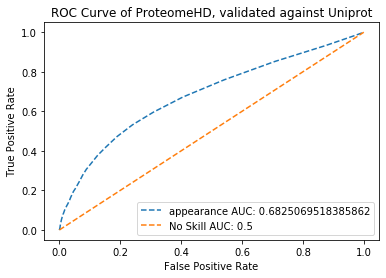

In [271]:
df_roc_analysis(proteomeHD_pred_df,['appearance'],'subcellular_location','ProteomeHD','Uniprot')

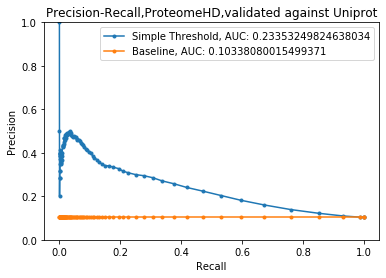

In [272]:
df_precision_recall_analysis(proteomeHD_pred_df['subcellular_location'].to_numpy(),
                             proteomeHD_pred_df['appearance'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,ProteomeHD,validated against Uniprot',
                             ylim=(0,1)
                            )

In [262]:
proteomeHD_pred_df_filtered = proteomeHD_pred_df.loc[proteomeHD_pred_df['appearance'] >= 15]
proteomeHD_pred_df_filtered

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
15,A0AVT1,P52565,21.0,0,0,0
120,A2RU67,Q99880,15.0,0,0,0
170,A4D1S0,O15229,17.0,0,0,0
185,A5A3E0,Q16635,15.0,0,0,0
210,A6NC86,P21757,16.0,0,0,0
...,...,...,...,...,...,...
51530,Q9Y6R1,O60656,16.0,0,0,0
51535,Q9Y6R4,Q9UGC7,15.0,0,0,0
51545,Q9Y6U3,Q14596,29.0,0,0,0
51560,Q9Y6W5,Q5W0V3,21.0,0,0,0


In [265]:
proteomeHD_self_ensemble_net = generate_network_from_df(proteomeHD_pred_df_filtered)
proteomeHD_self_ensemble_net_cliques = list(nx.find_cliques(proteomeHD_self_ensemble_net))
proteomeHD_verifiable_cliques = list(filter(is_corum_verifiable,proteomeHD_self_ensemble_net_cliques))
shuffled_proteomeHD_verifiable_cliques = shuffle_cliques_node_label(proteomeHD_verifiable_cliques)
proteomeHD_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),proteomeHD_self_ensemble_net_cliques))
print(f"Number of nodes: {len(proteomeHD_self_ensemble_net.nodes)}")
print(f"Number of edges: {len(proteomeHD_self_ensemble_net.edges)}")
print(f"Number of verifiable cliques: {len(proteomeHD_verifiable_cliques)}")
print(f"Number of unverifiable cliques: {len(proteomeHD_non_verifiable_cliques)}")

Number of nodes: 3567
Number of edges: 5447
Number of verifiable cliques: 840
Number of unverifiable cliques: 2793


In [264]:
full_report_dict = full_report_calculation_by_size(proteomeHD_verifiable_cliques)
simplified_report_df = simplifed_report_df(full_report_dict)
simplified_report_df = simplified_report_df.sort_values(by=['clique_size'])
simplified_report_df

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
2,2,190,517,0.367505,324
0,3,138,221,0.624434,45
1,4,53,76,0.697368,29
3,5,18,20,0.900000,15
4,6,6,6,1.000000,7


In [266]:
proteomeHD_full_report_dict_shuffled = full_report_calculation_by_size(shuffled_proteomeHD_verifiable_cliques)
proteomeHD_simplified_report_df_shuffled = simplifed_report_df(proteomeHD_full_report_dict_shuffled)
proteomeHD_simplified_report_df_shuffled = proteomeHD_simplified_report_df_shuffled.sort_values(by=['clique_size'])
proteomeHD_simplified_report_df_shuffled

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
2,2,10,517,0.019342,8
0,3,0,221,0.000000,0
1,4,0,76,0.000000,0
3,5,0,20,0.000000,0
4,6,0,6,0.000000,0


In [ ]:
proteomeHD_non_verifiable_5_cliques = list(filter(lambda x: len(x) == 4,proteomeHD_non_verifiable_cliques))
proteomeHD_non_verifiable_5_cliques

In [59]:
precision_xs = range(1,12)
precision_ys,precision_predictions = make_predictions_based_on_threshold(proteomeHD_simplified_protein_ids,
                                                                         proteomeHD_chunked_candidates,
                                                                         precision_xs,
                                                                         3)

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


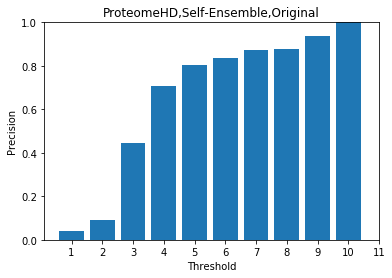

In [60]:
draw_bar(precision_xs,precision_ys,'Threshold','Precision','ProteomeHD,Self-Ensemble,Original',(0,1))

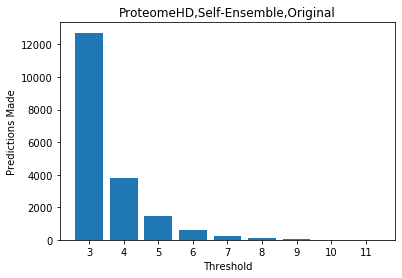

In [61]:
draw_bar(range(3,12),precision_predictions,'Threshold','Predictions Made','ProteomeHD,Self-Ensemble,Original')

In [18]:
full_report_dict[10]

KeyError: 10

## pQTL

In [182]:
CANDIDATE_SIZE = 5 # How many of the top appearing closest neighbors should each protein keep
NEIGHBOR_SIZE = 5 # How many closest neighbors should each protein considered
CHUNK_SIZE = 5 # Number of features in each splitted dataset
SAMPLE_SIZE = 100

In [183]:
#pQTL_protein_feature_matrix_shuffled = shuffle_column(pQTL_protein_feature_matrix)
%time pQTL_chunked_candidates = np.array(list(map(lambda x: generate_link_candidates(x,pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE),pQTL_protein_ids)))

Wall time: 2min 52s


In [228]:
pQTL_pred_df = convert_prediction_to_df(pQTL_protein_ids,pQTL_chunked_candidates[:,0],pQTL_chunked_candidates[:,1])
pQTL_pred_df = validate_relations_in_df(pQTL_pred_df)
pQTL_pred_df

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
0,O60762,Q9P2X0,6.0,1,1,0
1,O60762,P06744,5.0,0,0,0
2,O60762,P04075,4.0,0,0,0
3,O60762,P61225,3.0,0,0,0
4,O60762,Q9BQD3,3.0,0,0,0
...,...,...,...,...,...,...
21675,P62987,P83731,16.0,1,1,0
21676,P62987,Q02543,13.0,1,1,0
21677,P62987,P46777,11.0,1,1,1
21678,P62987,P62899,11.0,1,1,0


In [244]:
pQTL_pred_df.loc[(pQTL_pred_df['appearance'] >= 50) & (pQTL_pred_df['binary_interaction'] == 0) & (pQTL_pred_df['cocomplex'] == 0)& (pQTL_pred_df['subcellular_location'] == 0)]

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
1930,Q9H159,P00338,50.0,0,0,0
1945,P12814,Q8TCB0,57.0,0,0,0
2970,Q9BZ29,Q92835,58.0,0,0,0
9505,Q06203,Q14240,55.0,0,0,0
9640,P33316,P31350,53.0,0,0,0
17490,Q92835,Q9BZ29,56.0,0,0,0
18040,P31350,P33316,63.0,0,0,0
20075,P13645,Q9BZQ8,50.0,0,0,0
21360,Q6ZU69,P12814,55.0,0,0,0


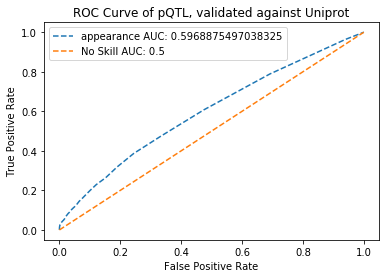

In [245]:
from visualization_util import df_roc_analysis
df_roc_analysis(pQTL_pred_df,['appearance'],'subcellular_location','pQTL','Uniprot')

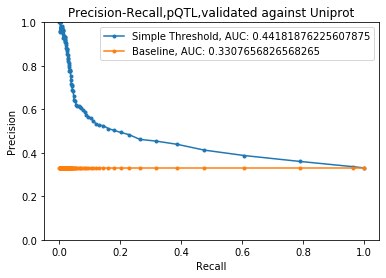

In [247]:
df_precision_recall_analysis(pQTL_pred_df['subcellular_location'].to_numpy(),
                             pQTL_pred_df['appearance'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,pQTL,validated against Uniprot',
                             ylim=(0,1)
                            )

In [248]:
pQTL_pred_df_filtered = pQTL_pred_df[pQTL_pred_df['appearance'] >= 15]
pQTL_pred_df_filtered

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
50,Q7L592,Q96ND0,18.0,0,0,1
75,P54819,Q9ULA0,22.0,0,0,0
76,P54819,O75223,16.0,0,0,0
77,P54819,Q9NQR4,16.0,0,0,0
175,P63010,O95782,23.0,1,0,1
...,...,...,...,...,...,...
21656,P13284,Q13557,17.0,0,0,0
21657,P13284,P16278,16.0,0,0,1
21658,P13284,Q2M2I8,15.0,0,0,0
21659,P13284,P10619,15.0,0,0,1


In [213]:
pQTL_self_ensemble_net = generate_network_from_df(pQTL_pred_df_filtered)
pQTL_self_ensemble_net_cliques = list(nx.find_cliques(pQTL_self_ensemble_net))
pQTL_verifiable_cliques = list(filter(is_corum_verifiable,pQTL_self_ensemble_net_cliques))
shuffled_pQTL_verifiable_cliques = shuffle_cliques_node_label(pQTL_verifiable_cliques)
pQTL_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),pQTL_self_ensemble_net_cliques))
print(f"Number of nodes: {len(pQTL_self_ensemble_net.nodes)}")
print(f"Number of edges: {len(pQTL_self_ensemble_net.edges)}")
print(f"Number of verifiable cliques: {len(pQTL_verifiable_cliques)}")
print(f"Number of unverifiable cliques: {len(pQTL_non_verifiable_cliques)}")

Number of nodes: 951
Number of edges: 1442
Number of verifiable cliques: 362
Number of unverifiable cliques: 480


In [249]:
pQTL_full_report_dict = full_report_calculation_by_size(pQTL_verifiable_cliques)
pQTL_simplified_report_df = simplifed_report_df(pQTL_full_report_dict)
pQTL_simplified_report_df = pQTL_simplified_report_df.sort_values(by=['clique_size'])
pQTL_simplified_report_df

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
2,2,122,195,0.625641,191
0,3,82,96,0.854167,35
1,4,47,51,0.921569,31
3,5,14,15,0.933333,11
4,6,5,5,1.000000,9


In [210]:
pQTL_full_report_dict_shuffled = full_report_calculation_by_size(shuffled_pQTL_verifiable_cliques)
pQTL_simplified_report_df_shuffled = simplifed_report_df(pQTL_full_report_dict_shuffled)
pQTL_simplified_report_df_shuffled = pQTL_simplified_report_df_shuffled.sort_values(by=['clique_size'])
pQTL_simplified_report_df_shuffled

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
2,2,9,195,0.046154,11
0,3,0,96,0.000000,0
1,4,1,51,0.019608,1
3,5,0,15,0.000000,0
4,6,0,5,0.000000,0


In [214]:
pQTL_full_report_dict[5]

{'total_cliques': 15,
 'hitting_cliques': [['Q9UI09', 'Q16795', 'O43181', 'P49821', 'P28331'],
  ['P24539', 'P25705', 'O75947', 'P36542', 'P06576'],
  ['P62841', 'P61254', 'P42766', 'P62753', 'P36578'],
  ['P49721', 'P25787', 'P25786', 'P25788', 'P25789'],
  ['P49721', 'P25787', 'P25786', 'P25788', 'O14818'],
  ['P20618', 'P25787', 'P25788', 'P25786', 'O14818'],
  ['P36578', 'P46779', 'P46778', 'P61313', 'P84098'],
  ['P36578', 'P46779', 'P46778', 'P62917', 'P42766'],
  ['P48643', 'P40227', 'Q99832', 'P78371', 'P49368'],
  ['P25786', 'P28066', 'P60900', 'P25788', 'P25787'],
  ['Q86Y39', 'Q9Y6M9', 'O43676', 'P17568', 'O95169'],
  ['O95167', 'Q16718', 'O75489', 'O95168', 'O96000'],
  ['Q9Y6M9', 'Q16795', 'O43676', 'P17568', 'O95169'],
  ['P78371', 'P40227', 'P49368', 'Q99832', 'P50991']],
 'non_hitting_cliques': [['P63244', 'P62249', 'P23396', 'P46782', 'P46781']],
 'corresponding_complexes': [[178],
  [563],
  [306, 3055],
  [181, 191, 192, 193, 194],
  [181, 191, 192, 193, 194],
  [181

In [211]:
x_range = range(1,100)
precision_ys,precision_predictions = make_predictions_based_on_threshold(pQTL_protein_ids,
                                                                         pQTL_chunked_candidates,
                                                                         x_range,
                                                                         1)

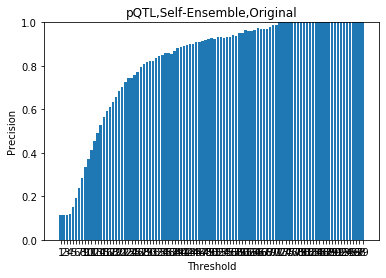

In [31]:
draw_bar(x_range,precision_ys,'Threshold','Precision','pQTL,Self-Ensemble,Original',(0,1))

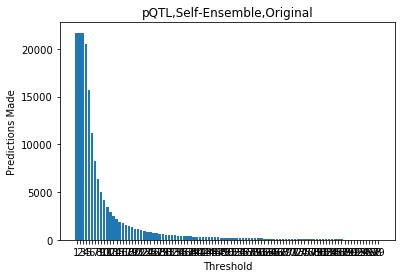

In [32]:
draw_bar(x_range,precision_predictions,'Threshold','Predictions Made','pQTL,Self-Ensemble,Original')

In [34]:
pQTL_pred_df_filtered = pQTL_pred_df.loc[pQTL_pred_df['appearance'] >= 99]
pQTL_pred_df_filtered

,protein_1,protein_2,appearance,binary_interaction,cocomplex
7195,Q01082,Q13813,100.0,1,0
11455,O95347,Q9NTJ3,100.0,1,1
20740,Q13813,Q01082,99.0,1,0


In [31]:
pQTL_full_report_dict[5]

{'total_cliques': 15,
 'hitting_cliques': [['P24539', 'P06576', 'P36542', 'P25705', 'O75947'],
  ['P24539', 'P06576', 'O75964', 'P25705', 'O75947'],
  ['P24539', 'P56385', 'P25705', 'O75947', 'P36542'],
  ['P24539', 'P56385', 'P25705', 'O75947', 'O75964'],
  ['P78371', 'P40227', 'Q99832', 'P49368', 'P50991'],
  ['P78371', 'P40227', 'Q99832', 'P49368', 'P48643'],
  ['Q9NTJ3', 'O95347', 'Q9BPX3', 'Q15021', 'Q15003'],
  ['P84098', 'P46778', 'P39023', 'P61313', 'P46777'],
  ['Q16795', 'O95169', 'Q9Y6M9', 'O43676', 'P17568'],
  ['O15511', 'P61160', 'O15145', 'P61158', 'O15144'],
  ['P61160', 'O15145', 'O15143', 'P61158', 'O15144'],
  ['P25789', 'P25786', 'P25787', 'P25788', 'P20618'],
  ['P25789', 'P25786', 'P25787', 'P25788', 'P49721'],
  ['P25789', 'P25786', 'P25787', 'P60900', 'P20618'],
  ['P49721', 'P25786', 'P25787', 'P25788', 'O14818']],
 'non_hitting_cliques': [],
 'corresponding_complexes': [[563],
  [563],
  [563],
  [563],
  [126],
  [126],
  [10, 157, 159, 167],
  [306, 308, 305

In [134]:
pQTL_non_verifiable_5_cliques = list(filter(lambda x: len(x) >= 9,pQTL_non_verifiable_cliques))
pQTL_non_verifiable_5_cliques

[]

In [218]:
%time pQTL_knn_candidates = np.array(list(map(lambda x: protein_query_simple(x,CANDIDATE_SIZE,euclidean_dist,pQTL_protein_ids,pQTL_protein_feature_matrix,pQTL_protein_idx_lookup),pQTL_protein_ids)))

In [219]:
pQTL_knn_interaction_counts = np.array(overall_interaction_counts(pQTL_protein_ids,pQTL_knn_candidates))
pQTL_knn_precision = np.sum(pQTL_knn_interaction_counts[:,0]) / np.sum(pQTL_knn_interaction_counts[:,1])
pQTL_knn_precision

0.13648523985239852

In [48]:
pQTL_knn_graph = construct_knn_network(pQTL_protein_ids,pQTL_protein_feature_matrix,5,euclidean_dist,pQTL_protein_idx_lookup)

NodeView(('O60762', 'Q15907', 'P61970', 'Q96S82', 'O95295', 'Q86XN8', 'Q8IZE3', 'Q8N3C0', 'Q9H269', 'O60524', 'Q9UJX4', 'O95155', 'P09769', 'Q96KP4', 'Q92623', 'Q9UJS0', 'Q92890', 'P09497', 'P48506', 'P13284', 'Q01469', 'P48426', 'Q9HCE1', 'O14933', 'Q16850', 'Q13907', 'Q16539', 'O00154', 'Q9BYT8', 'P26639', 'P28838', 'P40306', 'Q96KG9', 'Q06323', 'Q13325', 'Q9UL46', 'Q9Y6D9', 'Q8N163', 'Q12874', 'O75643', 'P57740', 'P13010', 'Q14847', 'Q9UJU6', 'P45974', 'Q07960', 'Q66K74', 'Q9Y5W9', 'P54619', 'P20073', 'Q9H7Z7', 'Q9UJY5', 'P40925', 'P20645', 'P07954', 'O95372', 'P51149', 'P53597', 'P24752', 'Q7L592', 'O75223', 'Q9UKG1', 'P23193', 'O00170', 'O43665', 'P52756', 'Q7KZ85', 'O43660', 'O60264', 'Q9UHX1', 'O43809', 'P84085', 'Q9H0U4', 'Q15370', 'O75165', 'Q9BT78', 'Q6SZW1', 'Q9UBM7', 'P24043', 'Q9BWD1', 'O95757', 'Q9Y2S7', 'Q9BYD6', 'Q9Y224', 'P63244', 'P62244', 'P55769', 'P54819', 'Q9NQR4', 'P36776', 'Q9GZP4', 'Q9ULA0', 'P28907', 'P61916', 'P42224', 'O94919', 'P68366', 'Q02790', 'Q5VYK3', 

In [49]:
pQTL_knn_graph_cliques = list(nx.find_cliques(pQTL_knn_graph))
pQTL_knn_graph_verifiable_cliques = list(filter(is_corum_verifiable,pQTL_knn_graph_cliques))
pQTL_knn_graph_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),pQTL_knn_graph_cliques))

In [50]:
pQTL_knn_graph_full_report_dict = full_report_calculation_by_size(pQTL_knn_graph_verifiable_cliques)
pQTL_knn_graph_simplified_report_df = simplifed_report_df(pQTL_knn_graph_full_report_dict)
pQTL_knn_graph_simplified_report_df = pQTL_knn_graph_simplified_report_df.sort_values(by=['clique_size'])
pQTL_knn_graph_simplified_report_df

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
1,2,63,864,0.072917,105
0,3,98,805,0.121739,54
2,4,98,400,0.245000,34
3,5,60,118,0.508475,11
4,6,17,19,0.894737,16


In [192]:
pQTL_full_report_dict[4]

{'total_cliques': 45,
 'hitting_cliques': [['P62750', 'P62906', 'P46778', 'P46777'],
  ['Q9UI09', 'Q16795', 'O43676', 'P17568'],
  ['Q9UI09', 'Q16795', 'P28331', 'O43181'],
  ['Q9UI09', 'Q16795', 'P28331', 'P17568'],
  ['P46776', 'Q02878', 'P61353', 'Q02543'],
  ['P46779', 'P62906', 'P46778', 'P46777'],
  ['P46779', 'P62906', 'P46778', 'P26373'],
  ['O14818', 'P25787', 'P25788', 'P28066'],
  ['P06576', 'P24539', 'P30049', 'P25705'],
  ['P62195', 'P35998', 'Q99460', 'Q13200'],
  ['P46781', 'P62249', 'P46782', 'P62854'],
  ['P62277', 'P62241', 'P30050', 'P62273'],
  ['P62277', 'P62241', 'P30050', 'P05388'],
  ['P51970', 'O95167', 'O95168', 'P19404'],
  ['P51970', 'O95167', 'O95168', 'O75489'],
  ['O75380', 'O75306', 'O95299', 'Q16718'],
  ['O75380', 'O75306', 'O95299', 'O43678'],
  ['P62851', 'P15880', 'P25398', 'P62888'],
  ['P62851', 'P15880', 'P61247', 'Q07020'],
  ['P62847', 'P62280', 'P61353', 'P62263'],
  ['Q07020', 'P61247', 'P15880', 'P18077'],
  ['P28331', 'Q16795', 'O95169', 'P

In [67]:
pQTL_chunked_interaction_counts = np.array(overall_interaction_counts(pQTL_protein_ids,pQTL_chunked_predictions))
pQTL_chunked_precision = np.sum(pQTL_chunked_interaction_counts[:,0]) / np.sum(pQTL_chunked_interaction_counts[:,1])
pQTL_chunked_precision

C:\Users\hoyin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


nan

In [73]:
np.sum(pQTL_chunked_interaction_counts[:,1])

404

In [73]:
pQTL_info_path = f"{PATH_ROOT}/data_sources/pQTL/pQTL_protein_info.json"

## nikolai

In [273]:
CANDIDATE_SIZE = 5 # How many of the top appearing closest neighbors should each protein keep
NEIGHBOR_SIZE = 5 # How many closest neighbors should each protein considered
CHUNK_SIZE = 5 # Number of features in each splitted dataset
SAMPLE_SIZE = 100

In [275]:
%time nikolai_chunked_candidates = np.array(list(map(lambda x: generate_link_candidates(x,nikolai_protein_ids,nikolai_protein_feature_matrix,nikolai_protein_idx_lookup,NEIGHBOR_SIZE,CHUNK_SIZE,SAMPLE_SIZE,CANDIDATE_SIZE),nikolai_protein_ids))) 

Wall time: 5min 32s


In [277]:
nikolai_pred_df = convert_prediction_to_df(nikolai_protein_ids,nikolai_chunked_candidates[:,0],nikolai_chunked_candidates[:,1])
nikolai_pred_df = validate_relations_in_df(nikolai_pred_df)
nikolai_pred_df

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
0,A0A0B4J2F2,P62491,3.0,0,0,0
1,A0A0B4J2F2,Q6ZWJ8,3.0,0,0,0
2,A0A0B4J2F2,Q15696,3.0,0,0,0
3,A0A0B4J2F2,Q6GYQ0,3.0,0,0,0
4,A0A0B4J2F2,Q8IWU2,2.0,0,0,0
...,...,...,...,...,...,...
13855,Q9Y6Z7,P51858,3.0,0,0,0
13856,Q9Y6Z7,Q13310,3.0,0,0,0
13857,Q9Y6Z7,Q8TF50,3.0,0,0,0
13858,Q9Y6Z7,P11413,3.0,0,0,0


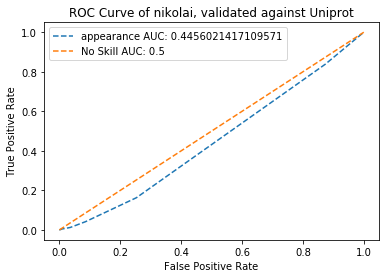

In [278]:
df_roc_analysis(nikolai_pred_df,['appearance'],'subcellular_location','nikolai','Uniprot')

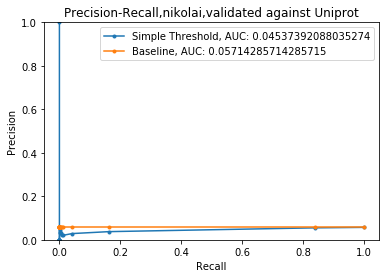

In [279]:
df_precision_recall_analysis(nikolai_pred_df['subcellular_location'].to_numpy(),
                             nikolai_pred_df['appearance'].to_numpy(),
                             'Simple Threshold',
                             'Precision-Recall,nikolai,validated against Uniprot',
                             ylim=(0,1)
                            )

In [281]:
nikolai_pred_df_filtered = nikolai_pred_df.loc[nikolai_pred_df['appearance'] >= 15]
nikolai_pred_df_filtered

,protein_1,protein_2,appearance,binary_interaction,cocomplex,subcellular_location
1430,O75600,Q99988,15.0,0,0,0
1960,P02545,P08670,15.0,0,0,0
2435,P08670,P07355,28.0,0,0,0
2436,P08670,P02545,21.0,0,0,0
4120,P34059,Q13206,20.0,0,0,0
9265,Q8IVF2,Q9HAT2,21.0,0,0,0
12075,Q9HAT2,Q8IVF2,21.0,0,0,0
12855,Q9P2K8,Q13206,20.0,0,0,0


In [282]:
nikolai_self_ensemble_net = generate_network_from_df(nikolai_pred_df_filtered)
nikolai_self_ensemble_net_cliques = list(nx.find_cliques(nikolai_self_ensemble_net))
nikolai_verifiable_cliques = list(filter(is_corum_verifiable,nikolai_self_ensemble_net_cliques))
shuffled_nikolai_verifiable_cliques = shuffle_cliques_node_label(nikolai_verifiable_cliques)
nikolai_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),nikolai_self_ensemble_net_cliques))
print(f"Number of nodes: {len(nikolai_self_ensemble_net.nodes)}")
print(f"Number of edges: {len(nikolai_self_ensemble_net.edges)}")
print(f"Number of verifiable cliques: {len(nikolai_verifiable_cliques)}")
print(f"Number of unverifiable cliques: {len(nikolai_non_verifiable_cliques)}")

Number of nodes: 10
Number of edges: 6
Number of verifiable cliques: 2
Number of unverifiable cliques: 4


In [283]:
nikolai_full_report_dict = full_report_calculation_by_size(nikolai_verifiable_cliques)
nikolai_simplified_report_df = simplifed_report_df(nikolai_full_report_dict)
nikolai_simplified_report_df = nikolai_simplified_report_df.sort_values(by=['clique_size'])
nikolai_simplified_report_df

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
0,2,0,2,0.0,0


In [284]:
nikolai_full_report_dict_shuffled = full_report_calculation_by_size(shuffled_nikolai_verifiable_cliques)
nikolai_simplified_report_df_shuffled = simplifed_report_df(nikolai_full_report_dict_shuffled)
nikolai_simplified_report_df_shuffled = nikolai_simplified_report_df_shuffled.sort_values(by=['clique_size'])
nikolai_simplified_report_df_shuffled

,clique_size,hitting_cliques,total_cliques,precision,complex_hit
0,2,0,2,0.0,0


In [43]:
nikolai_non_verifiable_4_cliques = list(filter(lambda x: len(x) >= 6,nikolai_non_verifiable_cliques))
nikolai_non_verifiable_4_cliques

[['Q5SSG8', 'O43283', 'B2RTY4', 'Q9NZU7', 'Q7RTX1', 'Q9P266'],
 ['Q5SSG8', 'O43283', 'B2RTY4', 'Q9NZU7', 'Q7RTX1', 'P35579'],
 ['Q5SSG8', 'O43283', 'B2RTY4', 'Q9NZU7', 'Q7RTX1', 'Q8WXD9'],
 ['Q5SSG8', 'O43283', 'B2RTY4', 'Q9NZU7', 'Q7RTX1', 'O75096'],
 ['Q5SSG8', 'O43283', 'B2RTY4', 'Q9NZU7', 'Q7RTX1', 'A6NI72'],
 ['Q5SSG8', 'O43283', 'B2RTY4', 'Q9NZU7', 'Q8IYI6', 'P01906'],
 ['Q5SSG8', 'B2RTY4', 'Q9NZU7', 'Q7RTX1', 'Q86V88', 'Q3LIE5'],
 ['Q9Y4E1', 'Q9HB75', 'P49755', 'P51826', 'Q99988', 'P11021'],
 ['O76064', 'Q9HAT2', 'Q8IVF2', 'Q6IAN0', 'O60279', 'Q9ULW3'],
 ['Q8IVF2', 'Q9HAT2', 'Q9NZM1', 'P06748', 'Q6IAN0', 'O60279'],
 ['P20648', 'Q15005', 'P13533', 'O43379', 'P56199', 'Q9P0K7'],
 ['P20648', 'Q15005', 'O15357', 'O43379', 'P56199', 'Q6XZB0'],
 ['P20648', 'Q15005', 'Q9NXF7', 'Q9H5V9', 'O14639', 'Q7RTV0'],
 ['P20648', 'Q15005', 'Q9NXF7', 'O43379', 'Q2TAC2', 'Q9BXY4'],
 ['P20648', 'Q15005', 'Q9NXF7', 'O43379', 'Q2TAC2', 'Q8WXI7'],
 ['P20648', 'Q15005', 'Q9NXF7', 'O43379', 'Q2TAC2', 'A6

In [227]:
%time nikolai_knn_candidates = np.array(list(map(lambda x: protein_query_simple(x,CANDIDATE_SIZE,euclidean_dist,nikolai_protein_ids,nikolai_protein_feature_matrix,nikolai_protein_idx_lookup),nikolai_protein_ids)))

Wall time: 1min


In [230]:
nikolai_knn_interaction_counts = np.array(overall_interaction_counts(nikolai_protein_ids,nikolai_knn_candidates))
nikolai_knn_precision = np.sum(nikolai_knn_interaction_counts[:,0]) / np.sum(nikolai_knn_interaction_counts[:,1])
nikolai_knn_precision

0.004329004329004329

# Control

## KNN

In [ ]:
# Only returns names of the top k nearest neighbors
def protein_query_simple(protein,k,dist_function,name_vector,feature_matrix,lookup):
    protein_idx = lookup[protein]
    protein_vec = feature_matrix[protein_idx]
    if dist_function.__name__ == 'euclidean_dist':
        diff_vec = feature_matrix - protein_vec
        norm_vec = np.linalg.norm(diff_vec, axis=1)
        top_indices = take_top_k(norm_vec,k+1)[1:]
        return name_vector[top_indices]
    else:
        neighbor_indices,_ = get_top_k_nearest_neighbors(protein_vec,k,feature_matrix,dist_function)
        return name_vector[neighbor_indices]

def construct_knn_network(name_vec,feature_matrix,k,dist_function,lookup):
    knn_graph = nx.Graph()
    for name in name_vec:
        neighbors = protein_query_simple(name,k,dist_function,name_vec,feature_matrix,lookup)
        for neighbor in neighbors:
            knn_graph.add_edge(name,neighbor)
    return knn_graph

In [ ]:
# ProteomeHD

In [ ]:
%time proteomeHD_knn_candidates = np.array(list(map(lambda x: protein_query_simple(x,CANDIDATE_SIZE,euclidean_dist,proteomeHD_simplified_protein_ids,proteomeHD_feature_matrix,major_simplified_idx_lookup),proteomeHD_simplified_protein_ids)))

In [ ]:
proteomeHD_knn_interaction_counts = np.array(overall_interaction_counts(proteomeHD_simplified_protein_ids,proteomeHD_knn_candidates))
proteomeHD_knn_precision = np.sum(proteomeHD_knn_interaction_counts[:,0]) / np.sum(proteomeHD_knn_interaction_counts[:,1])
proteomeHD_knn_precision

In [ ]:
proteomeHD_knn_graph = construct_knn_network(proteomeHD_simplified_protein_ids,proteomeHD_feature_matrix,5,euclidean_dist,major_simplified_idx_lookup)

In [ ]:
proteomeHD_knn_graph_cliques = list(nx.find_cliques(proteomeHD_knn_graph))
proteomeHD_knn_graph_verifiable_cliques = list(filter(is_corum_verifiable,proteomeHD_knn_graph_cliques))
proteomeHD_knn_graph_non_verifiable_cliques = list(filter(lambda x: not is_corum_verifiable(x),proteomeHD_knn_graph_cliques))

In [ ]:
proteomeHD_knn_graph_full_report_dict = full_report_calculation_by_size(proteomeHD_knn_graph_verifiable_cliques)
proteomeHD_knn_graph_simplified_report_df = simplifed_report_df(proteomeHD_knn_graph_full_report_dict)
proteomeHD_knn_graph_simplified_report_df = proteomeHD_knn_graph_simplified_report_df.sort_values(by=['clique_size'])
proteomeHD_knn_graph_simplified_report_df

# CNN Methods

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F

m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

# class Conv1DNet(nn.module):
    
#     def __init__(self):
#         super(Conv1DNet,self).__init__()
#         self.conv1 = nn.Conv1D()
    
#     def forward(self,x):
#         pass
        

SyntaxError: invalid syntax (<ipython-input-245-4b684acb21a3>, line 6)

In [243]:
output.shape

torch.Size([20, 33, 24])

In [244]:
input.shape

torch.Size([20, 16, 50])

## Correlation Method

In [7]:
proteomeHD_corr_mat = np.corrcoef(proteomeHD_feature_matrix)

In [11]:
proteomeHD_corr_candidates = []
for i in range(len(proteomeHD_corr_mat)):
    top_candidates = take_top_k(proteomeHD_corr_mat[i],CANDIDATE_SIZE+1,desc=True)[1:]
    proteomeHD_corr_candidates.append(proteomeHD_simplified_protein_ids[top_candidates])

In [12]:
proteomeHD_corr_interaction_counts = np.array(overall_interaction_counts(proteomeHD_simplified_protein_ids,proteomeHD_corr_candidates))
proteomeHD_corr_precision = np.sum(proteomeHD_corr_interaction_counts[:,0]) / np.sum(proteomeHD_corr_interaction_counts[:,1])
proteomeHD_corr_precision

0.05756078659304466